# H chain QEM

## Set experiment parameters

In [106]:
ibm_computer: str = "ibm_fez"
qubits = list(range(0, 14))  # [153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 136, 123, 124]
nshots: int = 20_000

len(qubits)

14

## Setup

In [107]:
from collections import Counter
from typing import Tuple

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import networkx as nx
import numpy as np
import pickle

from cirq.contrib.qasm_import import circuit_from_qasm
import openfermion as of

import qiskit
from qiskit import qasm2, qasm3
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from mitiq.interface.mitiq_qiskit import to_qiskit

### Helper functions

In [108]:
def pickle_load(file_name):
    my_file = open(file_name, "rb")
    data = pickle.load(my_file)
    my_file.close()
    return data

## Read in the Hamiltonian and ansatz circuit

In [109]:
hamiltonian = pickle_load("./H7_r=3_hamiltonian")
circuit = qasm3.load("./circuit")
# layout = pickle_load("./layout")

In [110]:
hamiltonian = of.get_fermion_operator(hamiltonian)

In [111]:
len(hamiltonian.terms)

4855

In [112]:
hamiltonian.compress(0.1)

In [113]:
len(hamiltonian.terms)

67

In [114]:
hamiltonian = of.jordan_wigner(hamiltonian)

In [115]:
hamiltonian = of.qubit_operator_to_pauli_sum(hamiltonian)

In [116]:
print(f"Hamiltonian acts on {len(hamiltonian.qubits)} qubit(s) and has {len(hamiltonian)} Pauli term(s).")

Hamiltonian acts on 14 qubit(s) and has 34 Pauli term(s).


In [117]:
print(hamiltonian)

-4.169*I+0.368*Z(q(0))+0.368*Z(q(1))+0.357*Z(q(2))+0.357*Z(q(3))+0.351*Z(q(4))+0.351*Z(q(5))+0.422*Z(q(6))+0.422*Z(q(7))+0.344*Z(q(8))+0.344*Z(q(9))+0.343*Z(q(10))+0.343*Z(q(11))+0.351*Z(q(12))+0.351*Z(q(13))+0.058*Z(q(0))*Z(q(1))+0.059*Z(q(0))*Z(q(12))+0.059*Z(q(0))*Z(q(13))+0.059*Z(q(1))*Z(q(12))+0.059*Z(q(1))*Z(q(13))+0.055*Z(q(2))*Z(q(3))+0.056*Z(q(2))*Z(q(10))+0.056*Z(q(2))*Z(q(11))+0.056*Z(q(3))*Z(q(10))+0.056*Z(q(3))*Z(q(11))+0.052*Z(q(4))*Z(q(5))+0.052*Z(q(4))*Z(q(8))+0.052*Z(q(4))*Z(q(9))+0.052*Z(q(5))*Z(q(8))+0.052*Z(q(5))*Z(q(9))+0.063*Z(q(6))*Z(q(7))+0.052*Z(q(8))*Z(q(9))+0.057*Z(q(10))*Z(q(11))+0.059*Z(q(12))*Z(q(13))


In [118]:
print(circuit.count_ops())

OrderedDict([('rz', 102), ('cx', 92), ('s', 46), ('sx', 42), ('x', 14), ('h', 7), ('barrier', 7)])


In [119]:
circuit.draw(fold=-1)

░                                                                                                                                                                  ░                                                                                                                                                   ░                                                                                                                                                                                                                                      ░                                                                                                                                                                                                                                       ░                                                                                                                                                                                                                                                                                                                            ░    ┌───┐   ┌───┐            ┌───┐┌──────────┐                                                                                                                                                                                                                                                            ░ 
 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░────┤ S ├───┤ H ├──────■─────┤ X ├┤ Rz(-π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─
                                                                                                                                                                                      ░                                                                                                                                                                  ░                                                                                                                                                   ░                                                                                                                                                                                                                                      ░                                                                                                                                                                                                                                       ░    ┌───┐   ┌───┐            ┌───┐┌──────────┐                             

In [120]:
circuit = qiskit.transpiler.passes.RemoveBarriers()(circuit)

## Connect to Qiskit runtime service

In [121]:
service = qiskit_ibm_runtime.QiskitRuntimeService() # This assumes a saved account.
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

computer_fractional_gates = service.backend(ibm_computer, use_fractional_gates=True)
sampler_fractional_gates = Sampler(computer_fractional_gates)

## Run experiment

In [122]:
compiled = qiskit.transpile(
    circuit,
    backend=computer,
    initial_layout=qubits,
    optimization_level=3,
)
compiled.draw(fold=-1, idle_wires=False)

global phase: 5π/4
                                                                         ┌────────┐   ┌────┐  ┌───────┐                                                                                                                                                                                                                                                            ┌────┐   ┌───────┐            ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
 <qiskit.circuit.quantumregister.Qubit object at 0x7fe1db35ec00> -> 0 ───┤ Rz(-π) ├───┤ √X ├──┤ Rz(π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────┤ √X ├───┤ Rz(π) ├─────■──────┤ √X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                         ├────────┤   ├────┤  ├───────┤                                                                                                                                                                                                             ┌────┐ ┌───────┐                    │          ├────┤   ├───────┤     │      └────┘                                       ┌────┐ ┌───────┐   ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                               
 <qiskit.circuit.quantumregister.Qubit object at 0x7fe1db683480> -> 1 ───┤ Rz(-π) ├───┤ √X ├──┤ Rz(π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ √X ├─┤ Rz(π) ├───────■────────────■──────────┤ √X ├───┤ Rz(π) ├─────■─────────────────────────────────────────────■─────┤ √X ├─┤ Rz(π) ├─■─┤ √X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                         ├────────┤   ├────┤  ├───────┤                                                                                                                                                        ┌────┐      ┌───────┐                        │       ├────┤ ├───────┤       │                       └────┘   └───────┘                              ┌────┐ ┌───────┐     │     ├────┤ ├───────┤ │ └────┘  ┌────┐  ┌───────┐   ┌────┐                                                                              

In [123]:
compiled.count_ops()

OrderedDict([('sx', 157), ('rz', 152), ('cz', 90), ('x', 3)])

In [124]:
157+152+3

312

In [125]:
def get_measured_circuit(
    circuit: qiskit.QuantumCircuit,
    creg_name: str = "meas",
) -> Tuple[qiskit.QuantumCircuit, qiskit.ClassicalRegister]:
    to_run = circuit.copy()
    to_run.measure_active()
    return to_run

In [126]:
to_run = get_measured_circuit(compiled)

In [127]:
to_run.draw(fold=-1, idle_wires=False)

global phase: 5π/4
                                                                         ┌────────┐   ┌────┐  ┌───────┐                                                                                                                                                                                                                                                            ┌────┐   ┌───────┐            ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ░ ┌─┐                                       
 <qiskit.circuit.quantumregister.Qubit object at 0x7fe1db35ec00> -> 0 ───┤ Rz(-π) ├───┤ √X ├──┤ Rz(π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────┤ √X ├───┤ Rz(π) ├─────■──────┤ √X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├───────────────────────────────────────
                                                                         ├────────┤   ├────┤  ├───────┤                                                                                                                                                                                                             ┌────┐ ┌───────┐                    │          ├────┤   ├───────┤     │      └────┘                                       ┌────┐ ┌───────┐   ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                ░ └╥┘┌─┐                                    
 <qiskit.circuit.quantumregister.Qubit object at 0x7fe1db683480> -> 1 ───┤ Rz(-π) ├───┤ √X ├──┤ Rz(π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ √X ├─┤ Rz(π) ├───────■────────────■──────────┤ √X ├───┤ Rz(π) ├─────■─────────────────────────────────────────────■─────┤ √X ├─┤ Rz(π) ├─■─┤ √X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫─┤M├────────────────────────────────────
                                                                         ├────────┤   ├────┤  ├───────┤                                                                                                                                                        ┌────┐      ┌───────┐                        │       ├────┤ ├───────┤       │                       └────┘   └───────┘        

## Noiseless result

In [128]:
job = AerSimulator().run(to_run, shots=nshots)

In [129]:
counts_all = {np.binary_repr(int(z, 16), len(qubits)): count for z, count in job.result().data().get("counts").items()}
counts_all

{'01011010100110': 314,
 '01010110010110': 247,
 '10010110011010': 297,
 '10101001101010': 365,
 '01101001011010': 297,
 '10101010100110': 403,
 '01100110100110': 316,
 '10011001010110': 310,
 '01011010011010': 281,
 '01101001100110': 341,
 '10011001011010': 323,
 '01101010011010': 347,
 '01010101100110': 249,
 '10011010011010': 326,
 '01011001101010': 282,
 '01010101010110': 224,
 '10010101100110': 280,
 '01100101011010': 272,
 '10101010010110': 367,
 '10010101011010': 267,
 '01100101100110': 273,
 '01101010100110': 334,
 '01011010010110': 256,
 '10011001101010': 334,
 '10101010101010': 420,
 '10010110100110': 316,
 '10100110010110': 335,
 '01101001010110': 318,
 '10010101010110': 290,
 '01100110011010': 317,
 '01010101101010': 242,
 '01011001011010': 270,
 '01010110101010': 286,
 '01100110010110': 262,
 '10011010010110': 318,
 '01100101101010': 303,
 '10011010101010': 368,
 '10101001011010': 374,
 '10100110100110': 346,
 '01010110011010': 287,
 '10101010011010': 430,
 '01011001010110

In [130]:
def get_counts_for(counts: dict[str, int], *qubits) -> Counter:
    new = Counter()
    for bitstring, number in counts.items():
        subselected = "".join(bitstring[q] for q in qubits)
        new[subselected] += number
    return new

In [131]:
get_counts_for(counts_all, 0, 1)

Counter({'10': 10646, '01': 9354})

In [141]:
qubit1 = 2
qubit2 = 3

In [142]:
counts = get_counts_for(counts_all, qubit1, qubit2)

In [143]:
exp_zz_ideal = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
) / nshots
exp_zz_ideal

-1.0

## Noisy result

In [144]:
job = sampler.run([to_run], shots=nshots)
# job = service.job("d1vvr4gkchbs73ca903g")

In [156]:
all_counts = [result.data.measure.get_counts() for result in job.result()]

In [157]:
counts = [get_counts_for(c, qubit1, qubit2) for c in all_counts][0]
counts

Counter({'10': 8638, '01': 7249, '11': 3106, '00': 1007})

In [158]:
exp_zz = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
) / nshots
exp_zz

-0.5887

## With fractional gates

In [30]:
job_fractional_gates = sampler_fractional_gates.run([to_run], shots=nshots)

In [52]:
all_counts_frac = [result.data.measure.get_counts() for result in job_fractional_gates.result()]

In [53]:
counts_frac = [get_counts_for(c, qubit1, qubit2) for c in all_counts_frac][0]
counts_frac

Counter({'10': 8771, '01': 7443, '11': 2759, '00': 1027})

In [54]:
exp_zz_frac = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts_frac.items()
) / nshots
exp_zz_frac

-0.6214

## With dynamical decoupling

In [145]:
sampler_dd = Sampler(computer)
sampler_dd.options.dynamical_decoupling.enable = True
sampler_dd.options.dynamical_decoupling.sequence_type = "XpXm"

In [146]:
job_dd = sampler_dd.run([to_run], shots=nshots)
# job_dd = service.job("d1vvt1okchbs73ca920g")

In [159]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]

In [160]:
counts_dd = [get_counts_for(c, qubit1, qubit2) for c in all_counts_dd][0]
counts_dd

Counter({'10': 7837, '01': 7533, '11': 3151, '00': 1479})

In [161]:
exp_zz_dd = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts_dd.items()
) / nshots
exp_zz_dd

-0.537

## With readout error mitigation

In [147]:
from qiskit_experiments.library import LocalReadoutError
from qiskit.result.distributions.quasi import QuasiDistribution 

from qiskit_experiments.library.characterization.analysis import LocalReadoutErrorAnalysis

In [148]:
experiment = LocalReadoutError(qubits)
result = experiment.run(computer)

In [163]:
mitigator = result.analysis_results("Local Readout Mitigator", dataframe=True).iloc[0].value

KeyboardInterrupt: 

In [ ]:
def apply_rem(
    counts: dict[str, int], 
    mitigator: "qiskit_experiments.LocalReadoutMitigator",
    *qubits) -> dict[str: int]:
    counts = get_counts_for(counts, *qubits)
    vec = np.zeros(2 ** len(qubits), dtype=float)
    for bitstring, count in counts.items():
        vec[int(bitstring, 2)] = count
    vec = vec / nshots
    assert np.allclose(vec.sum(), 1.0)

    mitigated_probs_quasi = mitigator.mitigation_matrix(qubits=qubits) @ vec
    mitigated_probs_quasi = QuasiDistribution({i: v for i, v in enumerate(mitigated_probs_quasi)})
    mitigated_counts = {
        bitstring: int(nshots * prob) for bitstring, prob in mitigated_probs_quasi.nearest_probability_distribution().binary_probabilities().items()
    }
    return mitigated_counts

In [ ]:
all_counts_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts]

In [ ]:
exp_zz_rem = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts_rem[0].items()
) / nshots
exp_zz_rem

In [62]:
all_counts_dd_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts_dd]

In [63]:
exp_zz_dd_rem = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts_dd_rem[0].items()
) / nshots
exp_zz_dd_rem

-0.58495

## With ZNE

In [149]:
from mitiq import zne

In [150]:
qasm2_circuit = qasm2.dumps(compiled)

compiled_cirq = circuit_from_qasm(qasm2_circuit.replace("qregless", "q"))

In [151]:
scale_factors = [1, 3, 5]

In [152]:
scaled_circuits_cirq = [zne.scaling.fold_global(compiled_cirq, scale_factor) for scale_factor in scale_factors]

In [153]:
scaled_circuits = [to_qiskit(circuit) for circuit in scaled_circuits_cirq]
scaled_circuits = qiskit.transpile(
    scaled_circuits,
    backend=computer,
    initial_layout=qubits,
    optimization_level=0,
)

In [154]:
to_run_scaled = [get_measured_circuit(scaled_circuit) for scaled_circuit in scaled_circuits]

In [155]:
job_zne = sampler.run(to_run_scaled, shots=nshots)
# job_zne = service.job("d1vvtd1mr05s73a71lbg")

In [84]:
all_counts_zne = [result.data.measure.get_counts() for result in job_zne.result()]

In [86]:
counts_zne = [get_counts_for(c, qubit1, qubit2) for c in all_counts_zne]
counts_zne

[Counter({'10': 8660, '01': 7274, '11': 2882, '00': 1184}),
 Counter({'10': 5717, '11': 5493, '01': 5362, '00': 3428}),
 Counter({'00': 5597, '01': 5032, '10': 4846, '11': 4525})]

In [87]:
exp_zz_vals = [
    sum(
        count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
    ) / nshots
    for counts in counts_zne
]
exp_zz_vals

[-0.5934, -0.1079, 0.0122]

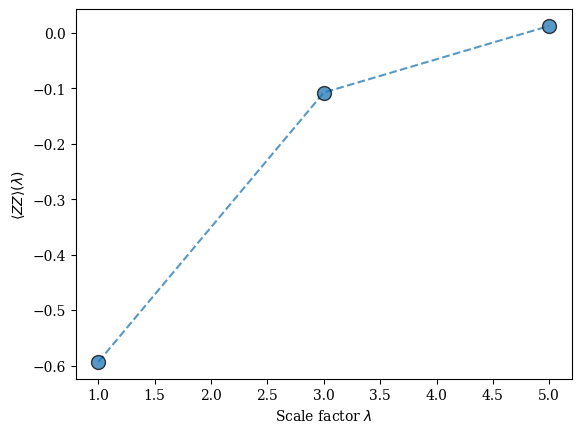

In [88]:
plt.plot(scale_factors, exp_zz_vals, "--o", ms=10, mec="black", alpha=0.75)
plt.xlabel(r"Scale factor $\lambda$")
plt.ylabel(rf"$\langle ZZ \rangle (\lambda) $");

In [91]:
exp_zz_zne = zne.inference.PolyFactory.extrapolate(
    scale_factors,
    exp_zz_vals,
    order=2,
)
exp_zz_zne

-0.9731749999999992

## ZNE + REM

In [93]:
counts_zne_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts_zne]

In [95]:
exp_zz_vals_zne_rem = [
    sum(
        count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
    ) / nshots
    for counts in counts_zne_rem
]
exp_zz_vals_zne_rem

[-0.6182, -0.11265, 0.01285]

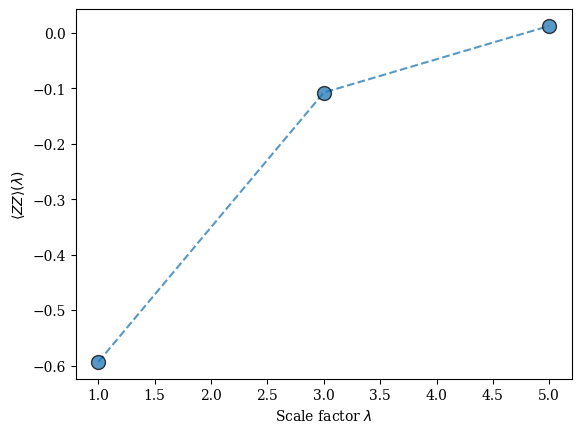

In [96]:
plt.plot(scale_factors, exp_zz_vals, "--o", ms=10, mec="black", alpha=0.75)
plt.xlabel(r"Scale factor $\lambda$")
plt.ylabel(rf"$\langle ZZ \rangle (\lambda) $");

In [99]:
exp_zz_zne_rem = zne.inference.PolyFactory.extrapolate(
    scale_factors,
    exp_zz_vals_zne_rem,
    order=2,
)
exp_zz_zne_rem

-1.013493749999999

## With decoherence renormalization

In [45]:
from typing import List, Optional


def get_echo_circuit(
    computer: qiskit_ibm_runtime.IBMBackend,
    qubits: List[int],
    depth: int,
    seed: Optional[int] = None,
) -> qiskit.QuantumCircuit:
    """Return a (Loschmidt) echo circuit.

    The circuit is built by applying random single-qubit rotations (angles set by `seed`)
    and layers of two-qubit gates which can be implemented on the `computer` to create a 
    unitary U. Then, the inverse unitary U^dag is applied. 

    Args:
        computer: Determines the implementable gates (unitaries and couplings) for the echo circuit.
        qubits: A subset of qubits on the computer to implement the echo on.
        depth: The number of layers of single-qubit rotations/two-qubit gates in U.
        seed: Determines the angle of rotations for random single-qubit rotations in each layer.
    """
    # Get a random state (determines the angles in single-qubit rotations).
    rng = np.random.RandomState(seed)
    
    # Get the subgraph.
    subgraph_edges = []
    
    for edge in computer.coupling_map.get_edges():
        if edge[0] in qubits and edge[1] in qubits:
            subgraph_edges.append(edge)
    
    graph = nx.Graph()
    graph.add_edges_from(subgraph_edges)
    
    # Get the two-qubit gate from the device. TODO: Handle cases where the two-qubit gate is neither ECR nor CNOT.
    two_qubit_gate = qiskit.circuit.library.ECRGate() if "ecr" in computer.configuration().basis_gates else qiskit.circuit.library.CZGate()
    
    # Group edges into sets in which two-qubit gates can be performed in parallel.
    edge_sets = [set()]
    
    for edge_index, edge in enumerate(graph.edges):
        for i, edge_set in enumerate(edge_sets):
            edge_added_to_a_set = False
            node_list = [e[0] for e in edge_set] + [e[1] for e in edge_set]
            if edge[0] in node_list or edge[1] in node_list:
                continue
            else:
                edge_sets[i].add(edge)
                edge_added_to_a_set = True
                break
    
        if not edge_added_to_a_set:
            edge_sets.append(set())
            edge_sets[-1].add(edge)

    # print("Found edge sets:")
    # print(edge_sets)
    
    # Get a circuit with the qubits on the computer.
    circuit = qiskit.QuantumCircuit()
    circuit = qiskit.transpile(circuit, backend=computer)
    
    rng = np.random.RandomState(seed=seed)
    
    for _ in range(depth):
        for edge_set in edge_sets:
            # Do a layer of single-qubit rotations.
            for qubit in graph.nodes():
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.RZGate(2 * np.pi * rng.normal()), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
    
            # Do a layer of two-qubit gates.
            for edge in edge_set:
                circuit.append(two_qubit_gate, qargs=[circuit.qubits[edge[0]], circuit.qubits[edge[1]]])
    
            # circuit.barrier()
    
    # Add the echo.
    circuit = circuit.compose(circuit.inverse())
    
    # Measure active qubits.
    if depth == 0:
        creg = qiskit.ClassicalRegister(len(graph.nodes()), name="meas")  # Note: This is hardcoded as `"meas"` to match the default name when `qiskit.QuantumCircuit.measure_active` is used.
        circuit.add_register(creg)
        for i, qubit in enumerate(sorted(graph.nodes())):
            circuit.measure(qubit, creg[i])
    else:
        circuit.measure_active()
    
    return circuit

In [46]:
echo = get_echo_circuit(computer, qubits, depth=4, seed=1)

In [47]:
echo.count_ops()

OrderedDict([('x', 448),
             ('rz', 224),
             ('cz', 104),
             ('measure', 14),
             ('barrier', 1)])

In [48]:
job_echo = sampler.run([echo], shots=nshots)

In [68]:
all_counts_echo = [result.data.measure.get_counts() for result in job_echo.result()]

In [69]:
renormalization = 1.0 - all_counts_echo[0].get("0" * len(qubits), 0) / nshots
renormalization

0.33314999999999995

In [70]:
exp_zz_drn = exp_zz / renormalization
exp_zz_drn

-1.8772324778628247

## Plot results

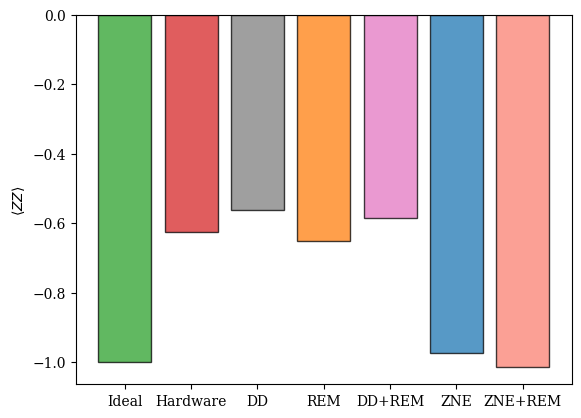

In [104]:
labels_vals = {
    "Ideal": exp_zz_ideal,
    "Hardware": exp_zz,
    "DD": exp_zz_dd,
    "REM": exp_zz_rem,
    "DD+REM": exp_zz_dd_rem,
    "ZNE": exp_zz_zne,
    "ZNE+REM": exp_zz_zne_rem,
}
colors = ["tab:green", "tab:red", "tab:grey", "tab:orange", "tab:pink", "tab:blue", "salmon"]
vals = list(labels_vals.values())
labels = list(labels_vals.keys())

plt.bar(range(len(vals)), vals, tick_label=labels, color=colors, edgecolor="black", alpha=0.75)
plt.ylabel(r"$\langle ZZ \rangle$");
plt.savefig("hchain_qem_v4.pdf")